In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from ignite.metrics import Accuracy, ConfusionMatrix, IoU, mIoU
from tqdm import tqdm
import logging
import sys
sys.path.append('/home/lindi/chenhr/threed/pointnext/seg')
from dataset import S3dis
from data_aug import *
import fps_cuda
import seaborn as sns
import matplotlib.pyplot as plt
from memorynet_seg_v1_x3x2_poly import Memorynet

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
val_aug = Compose([PointCloudFloorCentering(),
                        ColorNormalize()])
val_dataset = S3dis('/home/lindi/chenhr/threed/data/processed_s3dis', split='val', loop=1, transforms=val_aug)

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)

device = 'cuda:4'

model = Memorynet(13, 4, 32, [3, 6, 3, 3]).to(device)
model_path = '/home/lindi/chenhr/threed/pointnext/seg/memorynet_seg_v1_x3x2_poly_v2.pth'
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
model.eval()

val_dataloader = iter(val_dataloader)
for i in range(15):
    pos, x, y = next(val_dataloader)
pos = pos.to(device)
x = x.to(device)
y = y.to(device)

with torch.no_grad():
    _, _, attn_map, coarse_pred= model(pos, x, y)

coarse_pred = coarse_pred.transpose(1, 2).softmax(dim=-1)
print(attn_map.shape, coarse_pred.shape)
attn_map = attn_map.to(device='cpu').numpy()
coarse_pred = coarse_pred.to(device='cpu').numpy()

torch.Size([1, 1500, 13]) torch.Size([1, 1500, 13])


<AxesSubplot: >

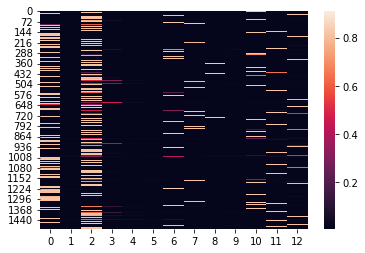

In [3]:
sns.heatmap(coarse_pred[0])

<AxesSubplot: >

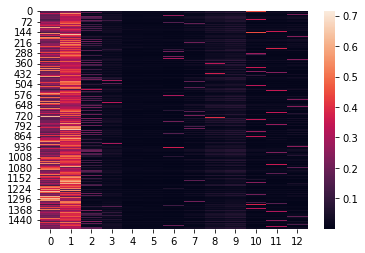

In [4]:
sns.heatmap(attn_map[0])

In [5]:
print(attn_map[0, 0:10])

[[0.15298615 0.21000494 0.01754594 0.03010316 0.01241915 0.0129095
  0.00765227 0.01397399 0.03763915 0.03950722 0.44718996 0.01046495
  0.00760362]
 [0.29794425 0.28345102 0.09078942 0.20305337 0.00877906 0.00800098
  0.00963023 0.01276262 0.02702183 0.03125269 0.00929787 0.00877307
  0.00924364]
 [0.18081817 0.33246607 0.20479321 0.02747311 0.01346213 0.0147275
  0.01475383 0.03443667 0.0498482  0.05830325 0.02301856 0.01996979
  0.02592949]
 [0.14501882 0.42663744 0.01192587 0.02605925 0.00780885 0.00877655
  0.00421128 0.00918491 0.02743267 0.0355957  0.2807489  0.00667916
  0.00992059]
 [0.1295018  0.26326913 0.24631836 0.04034026 0.02108174 0.0155853
  0.01710495 0.04913287 0.0741864  0.07290729 0.02646033 0.02112261
  0.02298903]
 [0.13196185 0.22539872 0.1969607  0.02555563 0.00963186 0.01165905
  0.00676203 0.01590835 0.03646998 0.04675881 0.00950056 0.27371752
  0.00971492]
 [0.43946862 0.47821158 0.00844683 0.00968956 0.00702105 0.00576292
  0.00408008 0.00456687 0.00920966 

In [6]:
print(coarse_pred[0, 0:10])

[[0.01629444 0.01521684 0.01588394 0.01522565 0.01583569 0.01500869
  0.01623577 0.0154357  0.01647165 0.01563619 0.8107364  0.0150599
  0.01695902]
 [0.29834282 0.02210625 0.31481847 0.22676909 0.01608704 0.01529623
  0.01993596 0.01321487 0.01736174 0.01734571 0.01405241 0.01283846
  0.01183095]
 [0.07793061 0.01722578 0.75253785 0.01655123 0.01458783 0.01600048
  0.01436912 0.01559178 0.01490621 0.01553827 0.01567262 0.01533478
  0.01375341]
 [0.01572935 0.01647517 0.01352163 0.01599391 0.01394318 0.01488358
  0.01496979 0.01412673 0.01404464 0.01514292 0.80065924 0.0140329
  0.03647692]
 [0.02426782 0.01947577 0.7913764  0.01862004 0.02141329 0.01443561
  0.01527801 0.01781626 0.01589617 0.01611227 0.01647995 0.01586067
  0.01296774]
 [0.01464562 0.01434991 0.4732152  0.0144005  0.01380488 0.01552255
  0.01229542 0.01416192 0.01470498 0.01617226 0.01323251 0.36946395
  0.01403033]
 [0.81315863 0.0155187  0.01639528 0.01536633 0.0154479  0.0150238
  0.01580297 0.01530281 0.01573889 